# CS3244 Project Pg34:
### Baseline CT - Augmented FVC forecasting to project pulmonary fibrosis progression, aiding medical decision-making and prognosis

Insert brief introduction here

### Imports:

Package imports:

In [2]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from evaluation.eval_template import *
from sklearn.linear_model import LinearRegression
from evaluation.eval_template import eval_metrics, laplace_log_likelihood


Tabular data import:

In [3]:
BASE_DIR = Path.cwd()
csv_path = BASE_DIR / "data" / "train.csv"

data = pd.read_csv(csv_path)
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


## Exploratory Data Analysis/ Image Data Preprocessing

### Tabular Data

Here is the outline of what each columns represent:  
Patient(str): unique ID for each patient  
Weeks(int): the relative number of weeks pre/post the baseline CT scan  
FVC(int): the recorded lung capacity in ml  
Percent(float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics  
Age(int), Sex(str), SmokingStatus(str)

For now, FVC readings measured pre-CT scans are dropped, then readings are grouped by patient IDs.

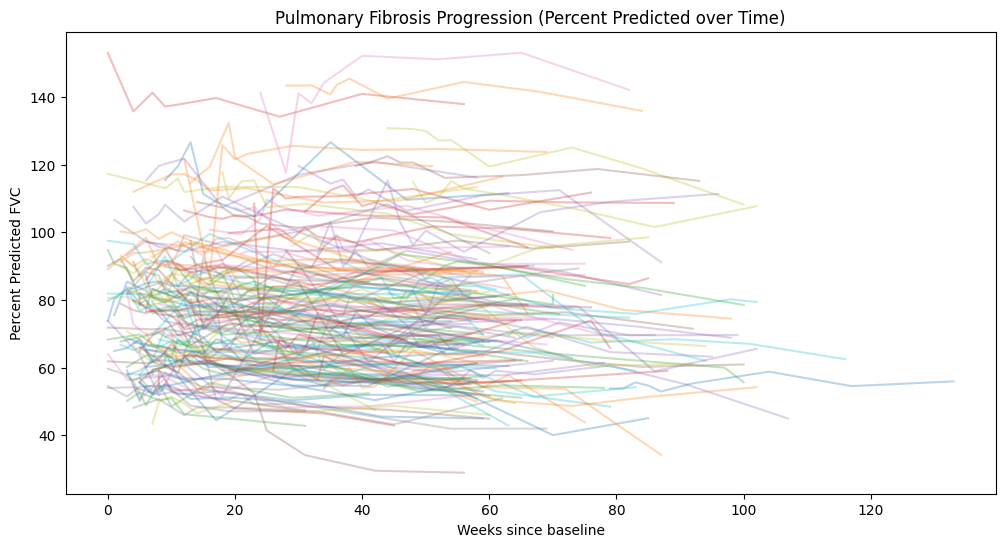

In [3]:
post_CT_data = data[data["Weeks"]>=0]
plt.figure(figsize=(12, 6))

for patient, pdata in post_CT_data.groupby("Patient"):
    plt.plot(pdata["Weeks"], pdata["Percent"], alpha=0.3)

plt.xlabel("Weeks since baseline")
plt.ylabel("Percent Predicted FVC")
plt.title("Pulmonary Fibrosis Progression (Percent Predicted over Time)")
plt.show()

Overall linear trend of decreasing percent values is observed. Now, effect of age is assessed, but there is a limitation: the readings are taken irregularly, so it is challenging to compute a metric that expresses change in FVC from week 30 to week 0. Instead, a percentage decline is computed then plotted.

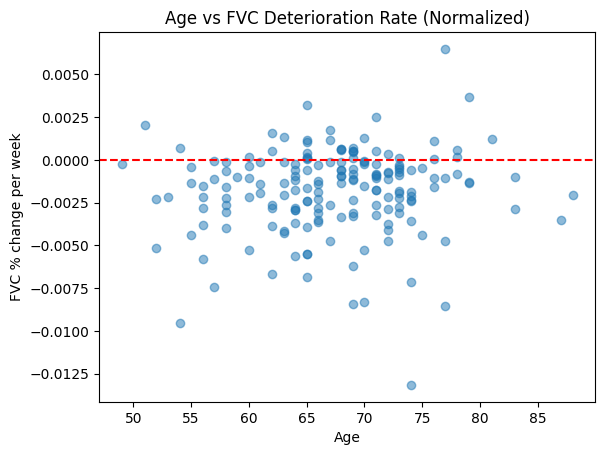

In [4]:
rates = []
ages = []

for patient, pdata in post_CT_data.groupby("Patient"):
    pdata = pdata.sort_values("Weeks")
    fvc_first = pdata["FVC"].iloc[0]
    fvc_last = pdata["FVC"].iloc[-1]
    t_first = pdata["Weeks"].iloc[0]
    t_last = pdata["Weeks"].iloc[-1]
    
    if t_last > t_first:  # avoid divide by zero
        decline_rate = (fvc_last - fvc_first) / (fvc_first * (t_last - t_first))
        rates.append(decline_rate)
        ages.append(pdata["Age"].iloc[0])

plt.scatter(ages, rates, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("FVC % change per week")
plt.title("Age vs FVC Deterioration Rate (Normalized)")
plt.axhline(0, color="red", linestyle="--")
plt.show()

Not much explicit correlation between age and relative FVC decline is shown in this plot. Moving on to sex:

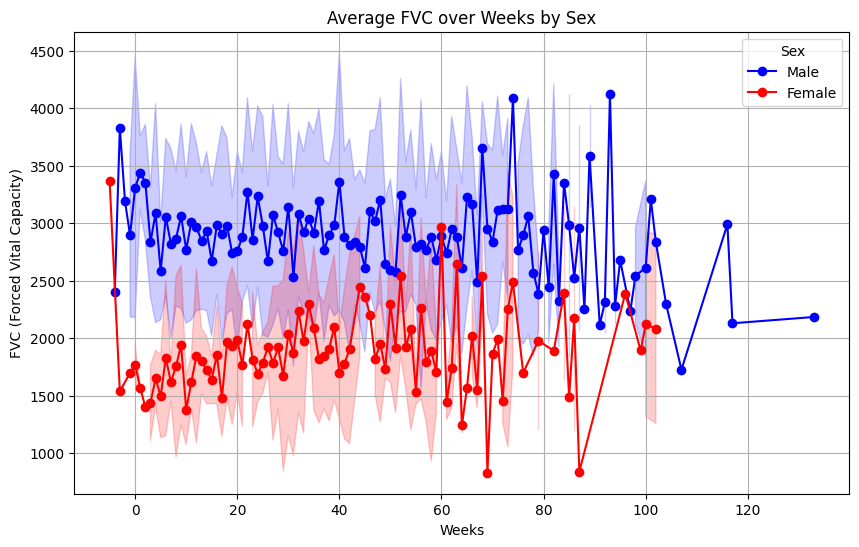

In [5]:
sex_weeks = data.groupby(["Weeks", "Sex"])["FVC"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(10,6))

# Plot Male
male = sex_weeks[sex_weeks["Sex"] == "Male"]
plt.plot(male["Weeks"], male["mean"], label="Male", color="blue", marker="o")
plt.fill_between(male["Weeks"], male["mean"] - male["std"], male["mean"] + male["std"],
                 alpha=0.2, color="blue")

# Plot Female
female = sex_weeks[sex_weeks["Sex"] == "Female"]
plt.plot(female["Weeks"], female["mean"], label="Female", color="red", marker="o")
plt.fill_between(female["Weeks"], female["mean"] - female["std"], female["mean"] + female["std"],
                 alpha=0.2, color="red")

plt.title("Average FVC over Weeks by Sex")
plt.xlabel("Weeks")
plt.ylabel("FVC (Forced Vital Capacity)")
plt.legend(title="Sex")
plt.grid(True)
plt.show()


The blue line (Male) is consistently higher than the red line (Female) which matches expectations since on average, males have larger lung volumes than females due to physiological differences (height, chest size, etc.).

Males (blue band) show larger variability in FVC compared to females. This means some males decline much faster/slower than others, while female patients are more tightly clustered around the average, suggesting more heterogeneity in the disease course of male patients. Most importantly, the rate of decline looks similar for both sexes.

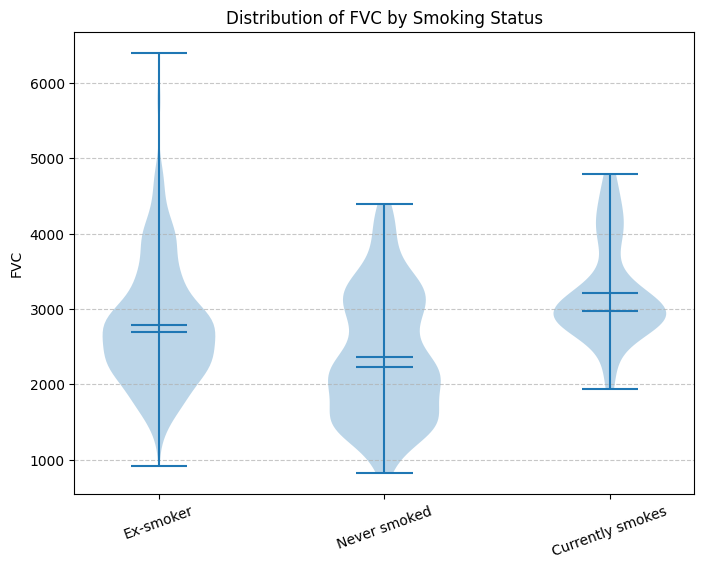

In [6]:
groups = [data.loc[data["SmokingStatus"] == status, "FVC"].dropna() 
          for status in data["SmokingStatus"].unique()]
labels = data["SmokingStatus"].unique()

plt.figure(figsize=(8,6))
plt.violinplot(groups, showmeans=True, showmedians=True)
plt.xticks(range(1, len(labels)+1), labels, rotation=20)
plt.title("Distribution of FVC by Smoking Status")
plt.ylabel("FVC")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()

Patients who currently smoke generally exhibit higher FVC values than those who have never smoked, while ex-smokers show a wider distribution with more variability and some very low values. This suggests that smoking history influences lung function, but the relationship is not entirely linear. Current smokers not always showing the lowest FVC, possibly due to sample variation or confounding factors such as age or disease severity.

### Image Data

For a rough assessment of the CT scans, we convert the raw DICOM files into Hounsfield Units (HU). This standardises the pixel intensities across patients and scanners, making the images easier to plot and compare.

In [7]:
# Import processed patient scans
# Must run preprocess/EDA_scans_preprocessing.py before loading

from preprocessing.EDA_scans_processing import *

processed_scans_hu_dir = BASE_DIR / "data" / "processed_scans_hu"
processed_scans = load_all_patients(processed_scans_hu_dir)

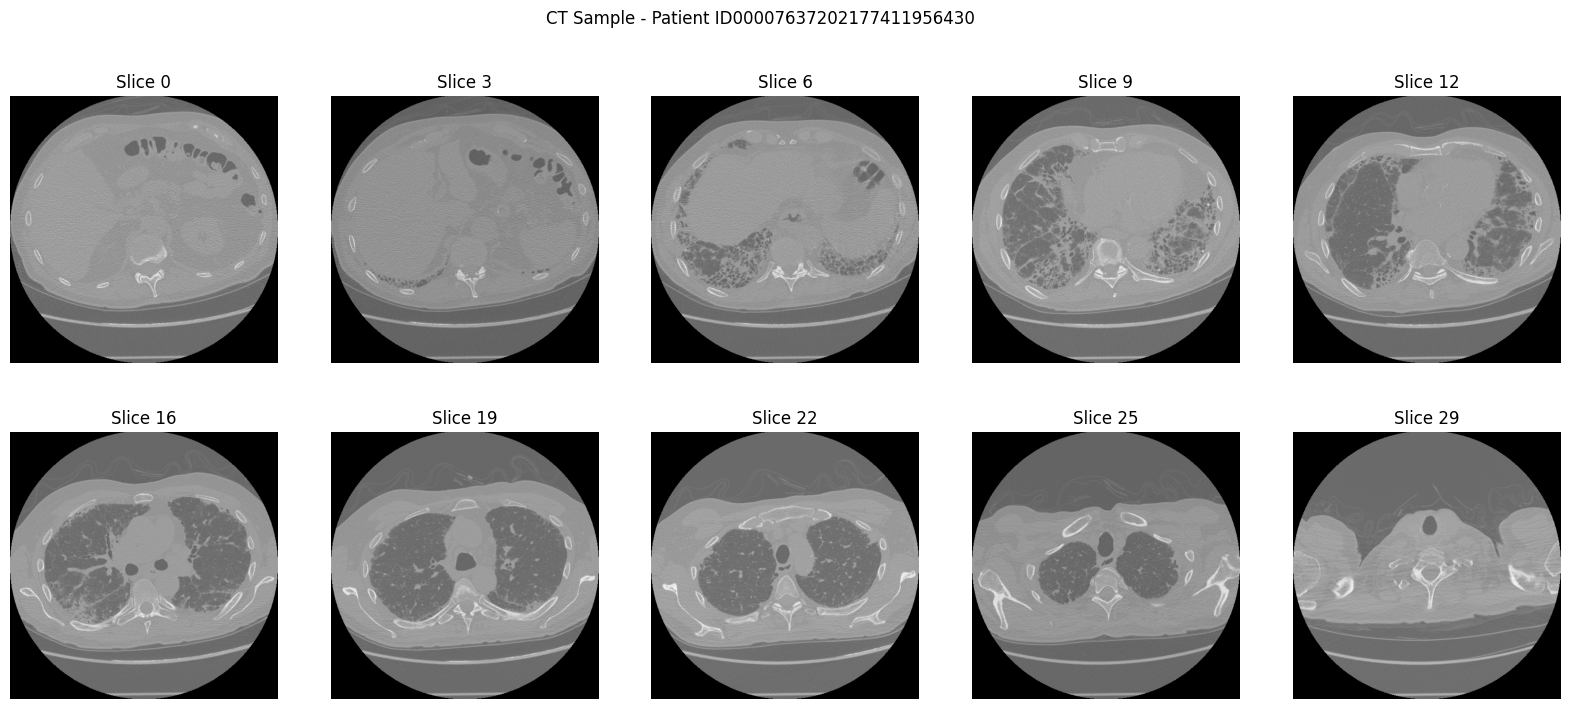

In [8]:
# Plotting random slice grids for 1st patient in the preprocessed scans for viewing
PATIENT = "ID00007637202177411956430"
scan = processed_scans[PATIENT]['volume']

indices = np.linspace(0, scan.shape[0]-1, 10, dtype=int)
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for ax, idx in zip(axes.flat, indices):
    ax.imshow(np.squeeze(scan[idx]), cmap='gray')
    ax.set_title(f"Slice {idx}")
    ax.axis('off')

plt.suptitle(f"CT Sample - Patient {PATIENT}")
plt.show()

Upon initial inspection of a sample patient's lung CT scan, we observe that each slice contains not only the lung tissue but also surrounding structures such as air outside the patient, bones, and other anatomy.

In [10]:
from preprocessing.preprocess import preprocess_scans, get_preprocessed_scan

# Change dir to local data dir
data_dir = BASE_DIR / 'osic-pulmonary-fibrosis-progression'
scan_dir = BASE_DIR / 'osic-pulmonary-fibrosis-progression' / 'preprocessed_scans_256'
if not os.path.exists(scan_dir):
    scans = preprocess_scans(data_dir)


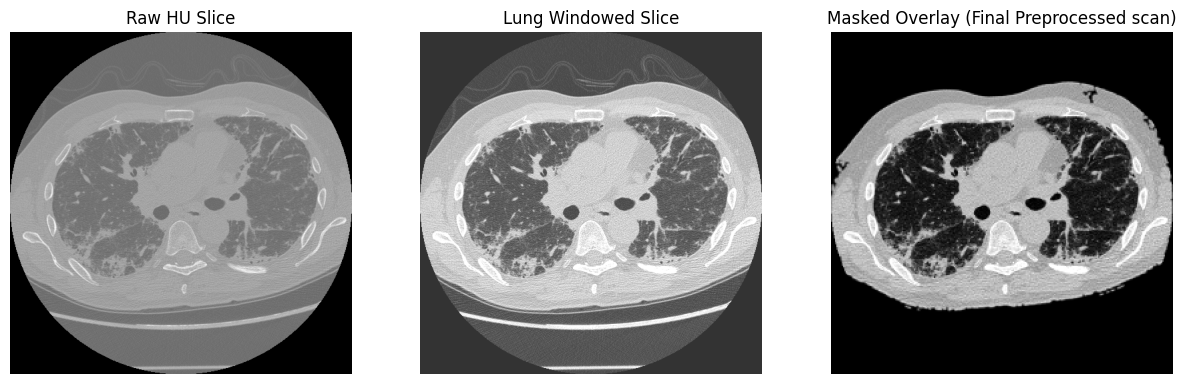

In [19]:
# Compare raw scan vs windowed scan
scan_v1 = processed_scans[PATIENT]['volume']
scan_v2 = get_preprocessed_scan(data_dir, PATIENT, 15)
plt.figure(figsize=(15, 5))
# Raw scan
plt.subplot(1,3,1)
plt.imshow(scan_v1[15], cmap='gray')
plt.title("Raw HU Slice")
plt.axis('off')

# Lung window (center=-600, width=1500)
windowed = np.clip(scan_v1[15], -1200, 400)
plt.subplot(1,3,2)
plt.imshow(windowed, alpha=0.8, cmap='gray')
plt.title("Lung Windowed Slice")
plt.axis('off')

# Masked overlay
plt.subplot(1,3,3)
plt.imshow(np.squeeze(scan_v2), cmap='gray')
plt.title("Masked Overlay (Final Preprocessed scan)")
plt.axis('off')
plt.show()

These three plots are compared to show the effect of each preprocessing step. The first plot shows the raw CT slice in Hounsfield Units (HU), highlighting the wide range of intensities and the presence of structures outside the lungs, such as bones and surrounding air. The second plot applies a lung window, which narrows the intensity range to focus on lung areas, enhancing visibility of relevant tissue while suppressing irrelevant high and low-density areas. The third plot shows the final preprocessed slice after masking and resizing, where non-lung regions are removed and the scan is standardized to a consistent shape. Together, these visualizations justify the need for windowing and masking, ensuring that downstream analyses or models focus on the lung regions of interest.

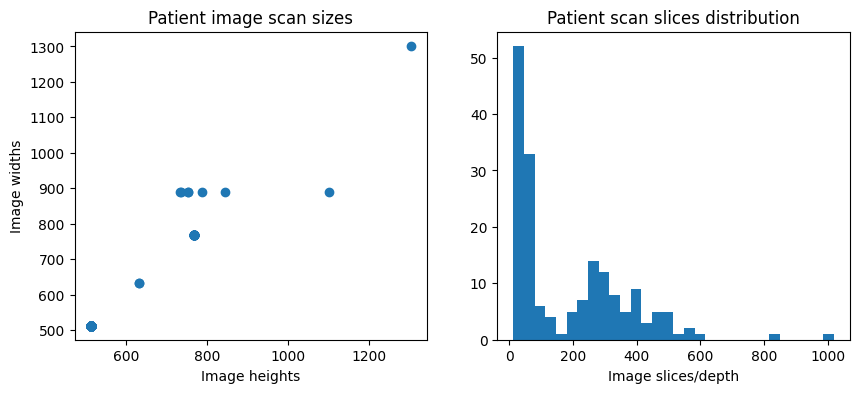

In [20]:
scan_shapes = []
scan_depths = []
for patient, data in processed_scans.items():
    shape = data['volume'].shape
    (height, width) = (shape[1], shape[2])
    scan_shapes.append((height, width))
    scan_depths.append(shape[0])

x = [element[0] for element in scan_shapes]
y = [element[1] for element in scan_shapes]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.xlabel("Image heights")
plt.ylabel("Image widths")
plt.title("Patient image scan sizes")

plt.subplot(1, 2, 2)
plt.hist(scan_depths, bins=30)
plt.xlabel("Image slices/depth")
plt.title("Patient scan slices distribution")
plt.show()

Pre-analysis of the processed CT scans also showed that both the number of slices per patient and slice dimensions vary across patients. To use these scans for predicting final FVC values with deep learning models, we would need to standardize input dimensions, for example via padding, cropping, or resampling. This ensures that all patient volumes can be processed in batches and that the network receives consistent input sizes.

## Baseline Unimodal Models

### Tabular Data: XGBoost

For the first baseline model, the longitudinal data is coerced into a single row to be pipelined into a simpler XGBoost model.

In row coercion, linearity is assumed and the grouped dataframe is collapsed by computing three features:
1. $\Delta t$ : the change in time from the second last reading from the first reading
2. $\Delta$ FVC : the change in FVC from the second last reading from the first reading
3. next_time : the change in time from the last reading which is being predicted to the second last reading

Then, the label will be the FVC reading from the last reading.

XGBoost Baseline Results:
MAE: 503.67928292410716
RMSE: 639.5878319723746
R²: 0.17197656631469727


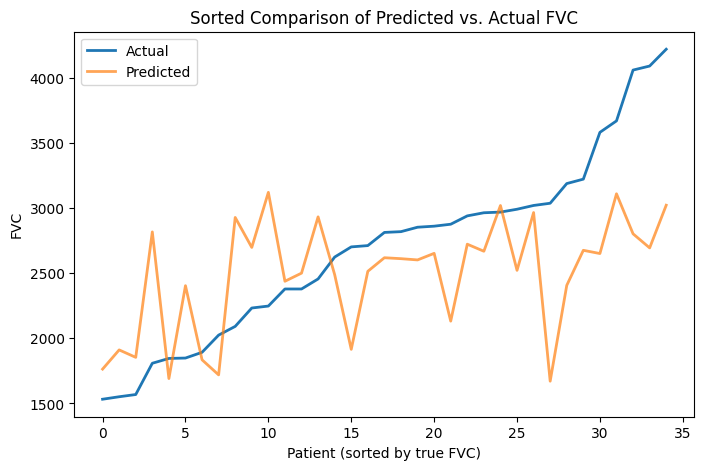

In [10]:
#sys.path.insert(0, str(BASE_DIR / "late_fusion"))
from models.baseline import X_train, X_val, y_train, y_val, baseline

# Train the model
baseline.fit(X_train, y_train)

baseline_y_val = y_val
baseline_y_pred = baseline.predict(X_val)
print(f"XGBoost Baseline Results:")
baseline_mae, baseline_rmse, baseline_r2 = eval_metrics(baseline_y_val, baseline_y_pred)
print("MAE:", baseline_mae)
print("RMSE:", baseline_rmse)
print("R²:", baseline_r2)

order = np.argsort(baseline_y_val)
y_true_sorted = np.array(baseline_y_val)[order]
y_pred_sorted = np.array(baseline_y_pred)[order]

plt.figure(figsize=(8, 5))
plt.plot(y_true_sorted, label="Actual", lw=2)
plt.plot(y_pred_sorted, label="Predicted", lw=2, alpha=0.7)
plt.title("Sorted Comparison of Predicted vs. Actual FVC")
plt.xlabel("Patient (sorted by true FVC)")
plt.ylabel("FVC")
plt.legend()
plt.show()

### Vision Data: Manual Feature Extraction

In [15]:
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, root_mean_squared_error
from models.manual_vision import initialize_models, get_dataset, get_predictions, get_idx_to_feature_name

x_train, y_train, x_val, y_val, x_test, y_test = get_dataset()


In [16]:
pcas, rf_regressors = initialize_models(x_train, y_train)

# Test each RF regressor on validation set
predictions = get_predictions(pcas, rf_regressors, x_test)

flattened_y = sum(list(y_test.values()), [])


Evaluating edge model...


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]



Evaluating corner model...


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]



Evaluating blob model...


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]



Evaluating lbp model...


100%|██████████| 5/5 [00:01<00:00,  3.43it/s]



Evaluating gabor model...


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


edge MAE: 168.45 ml
edge RMSE: 271.0104 ml
edge R²: 0.5129
----------
corner MAE: 131.87 ml
corner RMSE: 199.5279 ml
corner R²: 0.7360
----------
blob MAE: 147.85 ml
blob RMSE: 219.4680 ml
blob R²: 0.6805
----------
lbp MAE: 158.62 ml
lbp RMSE: 253.1532 ml
lbp R²: 0.5749
----------
gabor MAE: 142.66 ml
gabor RMSE: 230.7641 ml
gabor R²: 0.6468
----------


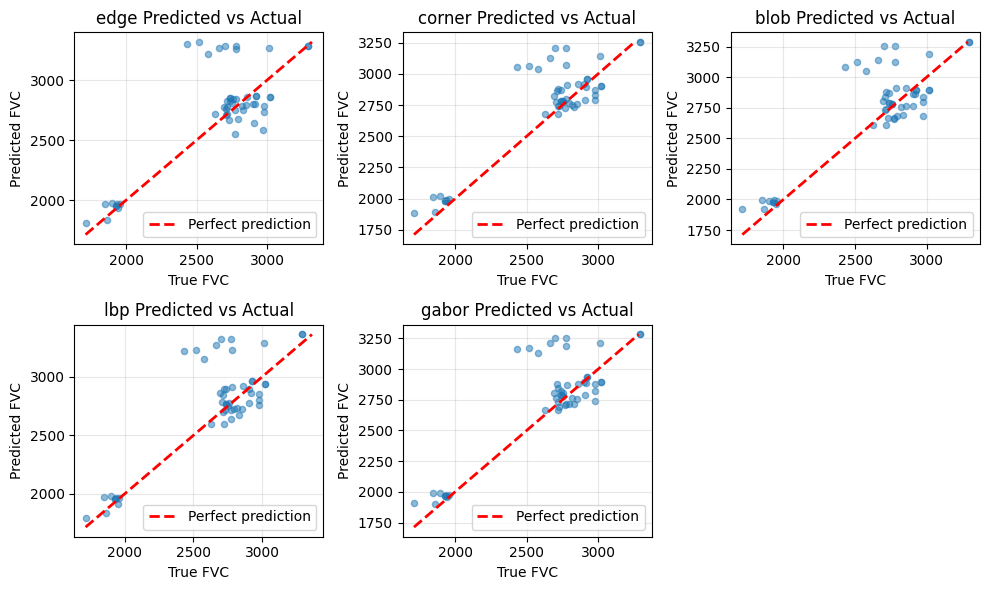

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for i in range(5):
    name = get_idx_to_feature_name(i)
    axs[i//3][i%3].scatter(flattened_y, predictions[i], alpha=0.5, s=20)
    axs[i//3][i%3].plot([min(flattened_y), predictions[i].max()], 
            [min(flattened_y), predictions[i].max()], 
            'r--', lw=2, label='Perfect prediction')
    axs[i//3][i%3].set_xlabel('True FVC')
    axs[i//3][i%3].set_ylabel('Predicted FVC')
    axs[i//3][i%3].set_title(f'{name} Predicted vs Actual')
    axs[i//3][i%3].legend()
    axs[i//3][i%3].grid(True, alpha=0.3)

    manual_mae, manual_rmse, manual_r2 = eval_metrics(flattened_y, predictions[i])
    print(f"{name} MAE: {manual_mae:.2f} ml")
    print(f"{name} RMSE: {manual_rmse:.4f} ml")
    print(f"{name} R²: {manual_r2:.4f}")
    print('-' * 10)


axs[1][2].remove()


plt.tight_layout()
plt.show()

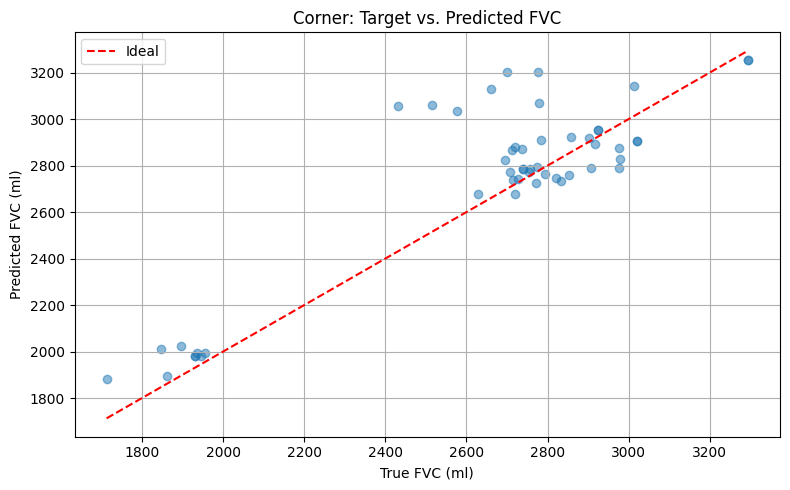

In [19]:
plt.figure(figsize=(8, 5))
plt.scatter(flattened_y, predictions[1], alpha=0.5)
plt.plot(
    [min(flattened_y), max(flattened_y)],
    [min(flattened_y), max(flattened_y)],
    'r--', label='Ideal'
)
plt.xlabel("True FVC (ml)")
plt.ylabel("Predicted FVC (ml)")
plt.title("Corner: Target vs. Predicted FVC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Tabular Data: GRU

Based on a related study: two real clinical EHR datasets (PhysioNet2012, MIMIC-III) establish that GRU-TV is a robust model on computer-aided diagnosis (CAD) tasks, especially on sequences with high-variance time intervals. (Liu & Gao, 2025).
Hence, we make a slight modification to the standard GRU and incorporate time-awareness architecture to better represent the clinical dataset

In [20]:
# Directly train and import GRU model results
from models.gru import gru_y_pred, gru_y_true, gru_y_std

ModuleNotFoundError: No module named 'models.gru'

In [8]:
# GRU evaluation metrics
gru_mae, gru_rmse, gru_r2 = eval_metrics(gru_y_true, gru_y_pred)
gru_residuals = gru_y_pred - gru_y_true
gru_lll = laplace_log_likelihood(gru_y_true, gru_y_pred, gru_y_std)
print(f"MAE:  {gru_mae:.4f} ml")
print(f"RMSE: {gru_rmse:.4f} ml")
print(f"laplace_log_likelihood: {gru_lll :.4f}")

print(f"\nResidual Statistics:")
print(f"Mean: {gru_residuals.mean():.4f}")
print(f"Std: {gru_residuals.std():.4f}")
print(f"Min: {gru_residuals.min():.4f}")
print(f"Max: {gru_residuals.max():.4f}")
print(f"R²: {gru_r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(gru_y_true, gru_y_pred, alpha=0.5, s=20)
plt.plot([gru_y_true.min(), gru_y_pred.max()], 
         [gru_y_true.min(), gru_y_pred.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC')
plt.ylabel('Predicted FVC')
plt.title('Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'eval_metrics' is not defined

### Tabular Data: Gaussian Process Regression

For the next baseline model, Gaussian Process (GP) is considered for the following reasons:
1. GP handles longitudinal data well, by modelling the temporal correlation and inter-patient covariance.
2. GP requires a lot less data than neural network and its variants

The initial, simpler attempt involved omitting patient ID and the subsequent inter-patient variance (refer to ./late_fusion/gaussian_process.py). Essentially, data from patients with similar demographic metadata were not differentiated before being passed into the model. 

It did not perform well, and thus the final GP model utilizes patient ID embeddings to capture individual temporal trajectories, but at inference the predictions on deviation of the new patient's FVC values from mean depending on the patient's demographic data.

In [13]:
# First time running this cell will take some time
from preprocessing.tabular_preprocessing import train_df, val_df
from models.gaussian_process import *

best_loss = float('inf')
best_model_state = None

for restart in range(5):
    print(f"\n=== Random Restart {restart + 1}/5 ===")
    
    # Reinitialize model and optimizer with random parameters
    likelihood_m2 = GaussianLikelihood()
    M2 = GPM2(X_time_train, X_age_train, X_baseline_train, pid_train, sex_train, smk_train, 
              y_train, likelihood_m2, n_patients, sex_card, smk_card, emb_dim=4)  # Increased to 4
    M2.train()
    likelihood_m2.train()
    optimizer_m2 = torch.optim.Adam(M2.parameters(), lr=0.01)
    mll_m2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_m2, M2)
    
    for i in range(5000):  
        optimizer_m2.zero_grad()
        weeks, age, baseline_fvc, sex, smk = M2.train_inputs 
        output = M2(weeks, age, baseline_fvc, sex, smk, use_patient_effects=True)
        loss = -mll_m2(output, y_train)
        loss.backward()
        optimizer_m2.step()
        
        if (i + 1) % 500 == 0:
            print(f"Iter {i+1}/5000 - Loss: {loss.item():.3f}")
    
    # Check if this restart achieved better loss
    final_loss = loss.item()
    if final_loss < best_loss:
        best_loss = final_loss
        best_model_state = M2.state_dict()
        print(f"New best loss: {best_loss:.3f}")

# Save the model for easier inference without retraining each time
gpm2_dir = BASE_DIR / 'models' / 'checkpoints' / 'gpm2_model_best.pth'

torch.save({
    "model_state_dict": best_model_state,
    "best_loss": best_loss
}, gpm2_dir)

print(f"Final GP2 model saved to {gpm2_dir}")

c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:655.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


RMSE: 0.7615, R²: -0.0427

=== Random Restart 1/5 ===
Iter 500/5000 - Loss: 0.833
Iter 1000/5000 - Loss: 0.379
Iter 1500/5000 - Loss: -0.312
Iter 2000/5000 - Loss: -0.609
Iter 2500/5000 - Loss: -0.622
Iter 3000/5000 - Loss: -0.628
Iter 3500/5000 - Loss: -0.626
Iter 4000/5000 - Loss: -0.635
Iter 4500/5000 - Loss: -0.636
Iter 5000/5000 - Loss: -0.640
New best loss: -0.640

=== Random Restart 2/5 ===
Iter 500/5000 - Loss: -0.509
Iter 1000/5000 - Loss: -0.637
Iter 1500/5000 - Loss: -0.639
Iter 2000/5000 - Loss: -0.640
Iter 2500/5000 - Loss: -0.644
Iter 3000/5000 - Loss: -0.642
Iter 3500/5000 - Loss: -0.645
Iter 4000/5000 - Loss: -0.643
Iter 4500/5000 - Loss: -0.642
Iter 5000/5000 - Loss: -0.645
New best loss: -0.645

=== Random Restart 3/5 ===
Iter 500/5000 - Loss: -0.593
Iter 1000/5000 - Loss: -0.644
Iter 1500/5000 - Loss: -0.647
Iter 2000/5000 - Loss: -0.645
Iter 2500/5000 - Loss: -0.644
Iter 3000/5000 - Loss: -0.643
Iter 3500/5000 - Loss: -0.625
Iter 4000/5000 - Loss: -0.645
Iter 4500/5

Loaded pretrained GP2 model with loss: -0.646
MAE: 0.2019
RMSE: 0.2716
Laplace Log-Likelihood: -4.5991

Residual Statistics:
Mean: 0.0642
Std: 0.2639
Min: -1.5212
Max: 0.6855
R squared: 0.8673087503388972


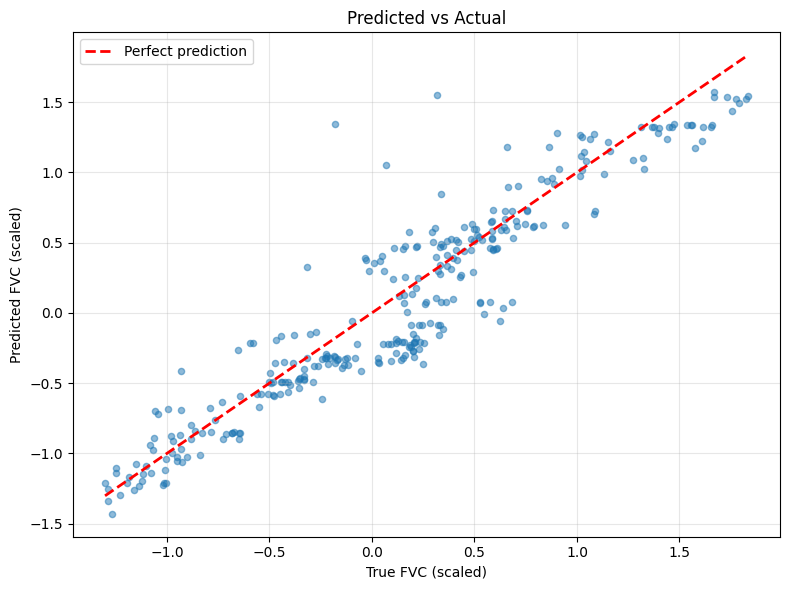

In [11]:
from models.gaussian_process import *

# Load the best GP2 model
gpm2_dir = BASE_DIR / 'models' / 'checkpoints' / 'gpm2_model_best.pth'
gpm2_checkpoint = torch.load(gpm2_dir)
likelihood_m2 = GaussianLikelihood()
M2 = GPM2(
    X_time_train, X_age_train, X_baseline_train,
    pid_train, sex_train, smk_train,
    y_train, likelihood_m2,
    n_patients, sex_card, smk_card,
    emb_dim=4
)

M2.load_state_dict(gpm2_checkpoint["model_state_dict"])
M2.eval()
likelihood_m2.eval()    # Fixed: was 'likelihood', should be 'likelihood_m2'
print(f"Loaded pretrained GP2 model with loss: {gpm2_checkpoint['best_loss']:.3f}")

X_time_val = torch.tensor(val_df[["Weeks_scaled"]].values, dtype=torch.float32)
X_age_val = torch.tensor(val_df[["Age"]].values, dtype=torch.float32)
X_baseline_val = torch.tensor(val_df[["Baseline_FVC"]].values, dtype=torch.float32)
sex_val = torch.tensor(val_df["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
smk_val = torch.tensor(val_df["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood_m2(M2(X_time_val, X_age_val, X_baseline_val, sex_val, smk_val, 
                         use_patient_effects=False))
    gp_y_pred = pred.mean.numpy()
    gp_y_std = pred.variance.sqrt().numpy()

gp_y_true = val_df["FVC_scaled"].values
gp_residuals = gp_y_true - gp_y_pred

gp_mae, gp_rmse, gp_r2 = eval_metrics(gp_y_true, gp_y_pred)
gp_lll = laplace_log_likelihood(gp_y_true, gp_y_pred, gp_y_std)
print(f"MAE: {gp_mae:.4f}")
print(f"RMSE: {gp_rmse:.4f}")
print(f"Laplace Log-Likelihood: {gp_lll:.4f}")
print(f"\nResidual Statistics:")
print(f"Mean: {gp_residuals.mean():.4f}")
print(f"Std: {gp_residuals.std():.4f}")
print(f"Min: {gp_residuals.min():.4f}")
print(f"Max: {gp_residuals.max():.4f}")
print(f"R squared: {gp_r2}")

plt.figure(figsize=(8, 6))
plt.scatter(gp_y_true, gp_y_pred, alpha=0.5, s=20)
plt.plot([gp_y_true.min(), gp_y_true.max()], 
         [gp_y_true.min(), gp_y_true.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC (scaled)')
plt.ylabel('Predicted FVC (scaled)')
plt.title('Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

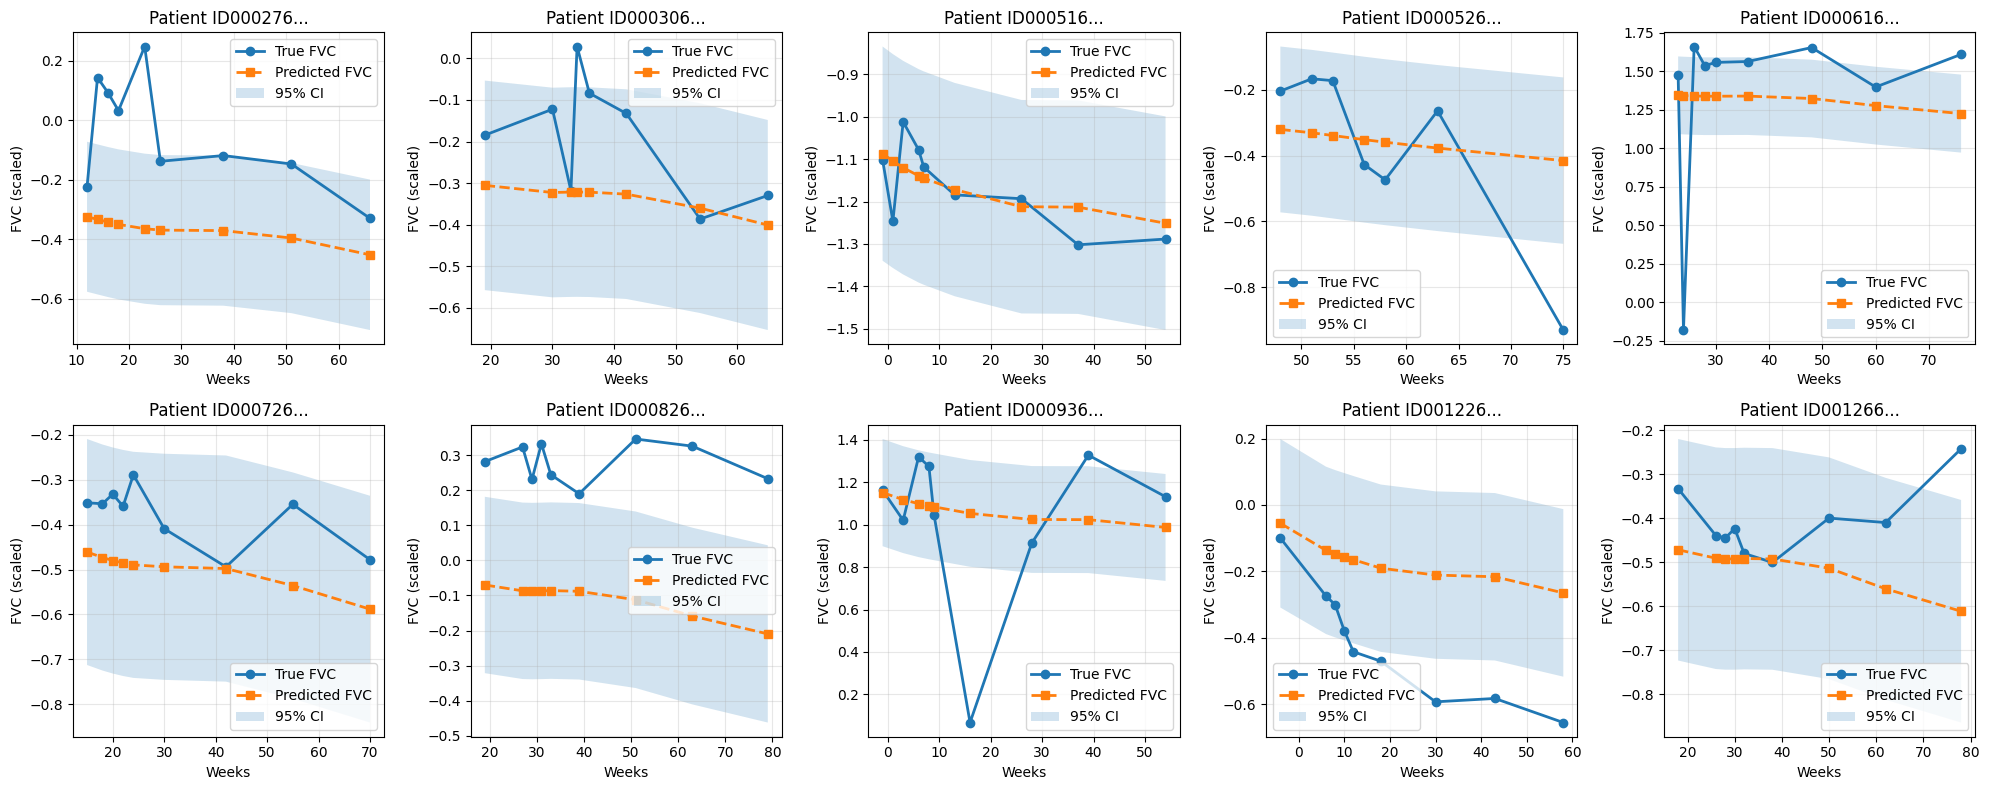

In [12]:
# Visualise a sample of patients' FVC prediction against FVC actual 
sample_patients = val_df['Patient'].unique()[:10]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, patient_id in enumerate(sample_patients):
    patient_data = val_df[val_df['Patient'] == patient_id].sort_values('Weeks')
    
    # Prepare patient-specific data
    X_time_patient = torch.tensor(patient_data[["Weeks_scaled"]].values, dtype=torch.float32)
    X_age_patient = torch.tensor(patient_data[["Age"]].values, dtype=torch.float32)
    X_baseline_patient = torch.tensor(patient_data[["Baseline_FVC"]].values, dtype=torch.float32)
    sex_patient = torch.tensor(patient_data["Sex"].map(sex_map).values, dtype=torch.long).unsqueeze(-1)
    smk_patient = torch.tensor(patient_data["SmokingStatus"].map(smk_map).values, dtype=torch.long).unsqueeze(-1)
    
    # Get predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_patient = likelihood_m2(M2(X_time_patient, X_age_patient, X_baseline_patient, 
                                      sex_patient, smk_patient, use_patient_effects=False))
        y_pred_patient = pred_patient.mean.numpy()
        y_std_patient = pred_patient.variance.sqrt().numpy()
    
    y_true_patient = patient_data["FVC_scaled"].values
    weeks = patient_data["Weeks"].values
    
    # Plot - use consistent 2D indexing
    row = idx // 5
    col = idx % 5
    axes[row, col].plot(weeks, y_true_patient, 'o-', label='True FVC', linewidth=2, markersize=6)
    axes[row, col].plot(weeks, y_pred_patient, 's--', label='Predicted FVC', linewidth=2, markersize=6)
    axes[row, col].fill_between(weeks, 
        y_pred_patient - 2*y_std_patient, 
        y_pred_patient + 2*y_std_patient, 
        alpha=0.2, label='95% CI')
    
    axes[row, col].set_xlabel('Weeks')
    axes[row, col].set_ylabel('FVC (scaled)')
    axes[row, col].set_title(f'Patient {patient_id[:8]}...')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Image Data: CNN regression

In [4]:
import torch
from torch.utils.data import DataLoader
from models.cnn import CNN, FCLayer, get_scans
from preprocessing.scan.preprocess import get_preprocessed_scan
from preprocessing.tabular_preprocessing import fvc_scaler, time_scaler, train_df, val_df
from collections import defaultdict
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model checkpoint
cnn_checkpoint = BASE_DIR / 'models' / 'checkpoints' / 'cnn_model_20251123_141346.pth'
print(f"Loading checkpoint from: {cnn_checkpoint}")
checkpoint = torch.load(cnn_checkpoint, map_location=device)
tabular_stats = checkpoint['tabular_stats']

# Initialize models
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
cnn_model.load_state_dict(checkpoint['cnn_state_dict'])
fc_model.load_state_dict(checkpoint['fc_state_dict'])

# Set to evaluation mode
cnn_model.eval()
fc_model.eval()

print("Models loaded successfully!")
print(f"Tabular stats: {tabular_stats}")

# Data directory for scans
# EDIT: Change dirname to your data directory's name
# data_dir = BASE_DIR / 'data'
data_dir = BASE_DIR / 'osic-pulmonary-fibrosis-progression/'

val_patient_id_to_initial_FVC = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
val_patient_id_to_initial_weeks = val_df.groupby('Patient')['Weeks_scaled'].first().to_dict()

val_x, val_y = defaultdict(list), defaultdict(list)
for idx, row in val_df.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks_scaled'], 
        'initial_FVC': val_patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': val_patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC_scaled'])

# Count scans per patient
scan_count = {}
train_dir = os.path.join(data_dir, 'train')
for patient_id in os.listdir(train_dir):
    patient_path = os.path.join(train_dir, patient_id)
    if os.path.isdir(patient_path):
        scan_count[patient_id] = len([f for f in os.listdir(patient_path) if f.endswith('.dcm')])

# Get CNN predictions for validation set
print(f"\nGetting CNN predictions for {len(val_x)} validation patients...")
print("Note: First run may be slow due to DICOM preprocessing and caching")

# REDUCE scan_batch_size from 64 to 16 to speed up significantly
SCAN_BATCH_SIZE = 16  

cnn_val_predictions = []
cnn_val_targets = []

with torch.no_grad():
    for patient_id in tqdm(val_x.keys(), desc="Processing patients"):
        if patient_id not in scan_count:
            print(f"Skipping {patient_id} - no scans found")
            continue
            
        # Load scans
        patient_scan_count = scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, scan_batch_size=SCAN_BATCH_SIZE)
        
        if scans is None:
            print(f"Skipping {patient_id} - failed to load scans")
            continue
        
        # Get image features
        features = cnn_model.forward(scans)
        features = torch.mean(features, dim=0)  # Average across slices
        
        x = val_x[patient_id]
        y = val_y[patient_id]
        
        # Get predictions for each timepoint
        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            cnn_val_predictions.append(output.item())
            cnn_val_targets.append(y[i])

cnn_val_predictions = np.array(cnn_val_predictions).reshape(-1, 1)
cnn_val_targets = np.array(cnn_val_targets)
print(f"CNN predictions shape: {cnn_val_predictions.shape}")
print(f"CNN predictions for {len(set([p for p in val_x.keys() if p in scan_count]))} patients\n")

# De-standardize predictions
cnn_val_predictions_real = fvc_scaler.inverse_transform(cnn_val_predictions).flatten()
cnn_val_targets_real = fvc_scaler.inverse_transform(np.array(cnn_val_targets).reshape(-1, 1)).flatten()

print("CNN model metrics:")
cnn_mae, cnn_rmse, cnn_r2 = eval_metrics(cnn_val_targets_real, cnn_val_predictions_real)
print(f"MAE: {cnn_mae:.2f} ml")
print(f"RMSE: {cnn_rmse:.4f} ml")
print(f"R²: {cnn_r2:.4f}")

Loading checkpoint from: c:\Coding\pulmonary_fibrosis\models\checkpoints\cnn_model_20251123_141346.pth
Models loaded successfully!
Tabular stats: {'fvc_mean': 2697.5761750405186, 'fvc_std': 853.7373140549034, 'weeks_mean': 31.055915721231766, 'weeks_std': 23.21059847431442}

Getting CNN predictions for 35 validation patients...
Note: First run may be slow due to DICOM preprocessing and caching


Processing patients: 100%|██████████| 35/35 [00:00<00:00, 46.12it/s]

CNN predictions shape: (310, 1)
CNN predictions for 35 patients

CNN model metrics:
MAE: 170.32 ml
RMSE: 230.8893 ml
R²: 0.8769


In [10]:
# Create plot for prediction sample in test set
from models.manual_vision import initialize_models, get_dataset, get_predictions, get_idx_to_feature_name
from preprocessing.tabular_preprocessing import fvc_scaler, time_scaler

x_train, y_train, x_val, y_val, x_test, y_test = get_dataset()

def transform_scalar_and_flatten(scaler, val):
    val = np.array(val).reshape(-1, 1)
    val = scaler.transform(val)
    val = val.flatten()[0]
    return val

for key, value in x_test.items():
    scaled_points = []
    initial_week = value[0]['week']
    scaled_initial_week = transform_scalar_and_flatten(time_scaler, initial_week)
    for point in value:
        scaled_week = transform_scalar_and_flatten(time_scaler, point['week'])
        scaled_fvc = transform_scalar_and_flatten(fvc_scaler, point['initial_FVC'])
        scaled_points.append({
            'Weeks': scaled_week, 
            'initial_FVC': scaled_fvc,
            'initial_weeks': scaled_initial_week,
        })
    x_test[key] = scaled_points

for key, value in y_test.items():
    targets = []
    for point in value:
        scaled_fvc = transform_scalar_and_flatten(fvc_scaler, point)
        targets.append(scaled_fvc)
    y_test[key] = targets

c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Coding\pulmonary_fibrosis\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  


Getting CNN predictions for 5 validation patients...
Note: First run may be slow due to DICOM preprocessing and caching


Processing patients: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]

CNN predictions shape: (50, 1)
CNN predictions for 5 patients

CNN model metrics:
MAE: 172.36 ml
RMSE: 209.7872 ml
R²: 0.7081


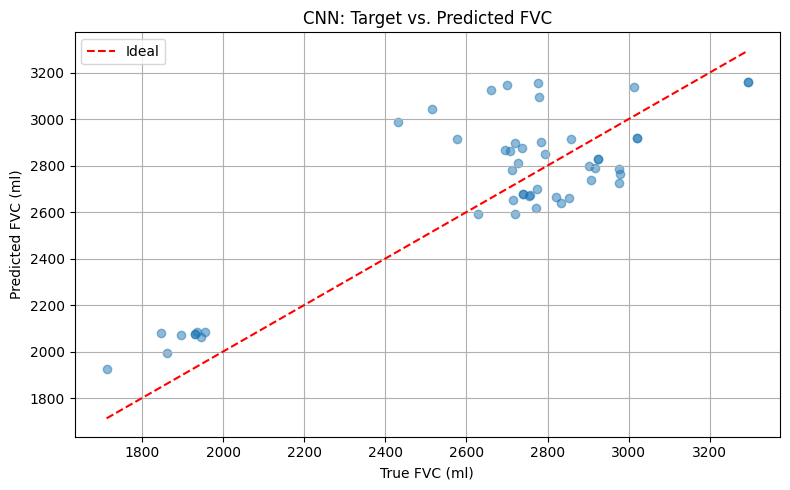

In [13]:
from preprocessing.preprocess import get_test_preprocessed_scan

# Count scans per patient
scan_count = {}
test_dir = os.path.join(data_dir, 'test')
for patient_id in os.listdir(test_dir):
    patient_path = os.path.join(test_dir, patient_id)
    if os.path.isdir(patient_path):
        scan_count[patient_id] = len([f for f in os.listdir(patient_path) if f.endswith('.dcm')])

# Get CNN predictions for validation set
print(f"\nGetting CNN predictions for {len(x_test)} validation patients...")
print("Note: First run may be slow due to DICOM preprocessing and caching")

# REDUCE scan_batch_size from 64 to 16 to speed up significantly
SCAN_BATCH_SIZE = 16  

cnn_predictions = []
cnn_targets = []

with torch.no_grad():
    for patient_id in tqdm(x_test.keys(), desc="Processing patients"):
        if patient_id not in scan_count:
            print(f"Skipping {patient_id} - no scans found")
            continue
            
        # Load scans
        patient_scan_count = scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, scan_batch_size=SCAN_BATCH_SIZE)
        
        if scans is None:
            print(f"Skipping {patient_id} - failed to load scans")
            continue
        
        # Get image features
        features = cnn_model.forward(scans)
        features = torch.mean(features, dim=0)  # Average across slices
        
        x = x_test[patient_id]
        y = y_test[patient_id]
        
        # Get predictions for each timepoint
        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            cnn_predictions.append(output.item())
            cnn_targets.append(y[i])

cnn_predictions = np.array(cnn_predictions).reshape(-1, 1)
cnn_targets = np.array(cnn_targets)
print(f"CNN predictions shape: {cnn_predictions.shape}")
print(f"CNN predictions for {len(set([p for p in x_test.keys() if p in scan_count]))} patients\n")

# De-standardize predictions
cnn_predictions_real = fvc_scaler.inverse_transform(cnn_predictions).flatten()
cnn_targets_real = fvc_scaler.inverse_transform(np.array(cnn_targets).reshape(-1, 1)).flatten()

print("CNN model metrics:")
cnn_mae, cnn_rmse, cnn_r2 = eval_metrics(cnn_targets_real, cnn_predictions_real)
print(f"MAE: {cnn_mae:.2f} ml")
print(f"RMSE: {cnn_rmse:.4f} ml")
print(f"R²: {cnn_r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(cnn_targets_real, cnn_predictions_real, alpha=0.5)
plt.plot(
    [min(cnn_targets_real), max(cnn_targets_real)],
    [min(cnn_targets_real), max(cnn_targets_real)],
    'r--', label='Ideal'
)
plt.xlabel("True FVC (ml)")
plt.ylabel("Predicted FVC (ml)")
plt.title("CNN: Target vs. Predicted FVC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Approach 1: Late Fusion

For a late fusion approach, two unimodal models, each based on tabular and image data, are combined after inidividual training, in an attempt for them to complement each other in the decision-making process.

Firstly, Gaussian Process (for tabular data) and CNN (for image data) are fused together to complete the multimodal approach.

Preparing GP predictions...
GP predictions shape: (315, 1)

Stacking predictions...
Training linear regression for optimal weights...

De-standardizing predictions...

=== Late Fusion Results (Real FVC values) ===
GP Weight: 0.6973
CNN Weight: 0.3388
Intercept: 0.0060

Final MAE: 138.99 ml
Final R²: 0.9303
Final Laplace Log-Likelihood: -7.3787

=== Individual Model Performance (Real FVC values) ===
GP-only MAE: 146.37 ml
GP-only R²: 0.9272
CNN-only MAE: 174.07 ml
CNN-only R²: 0.9043


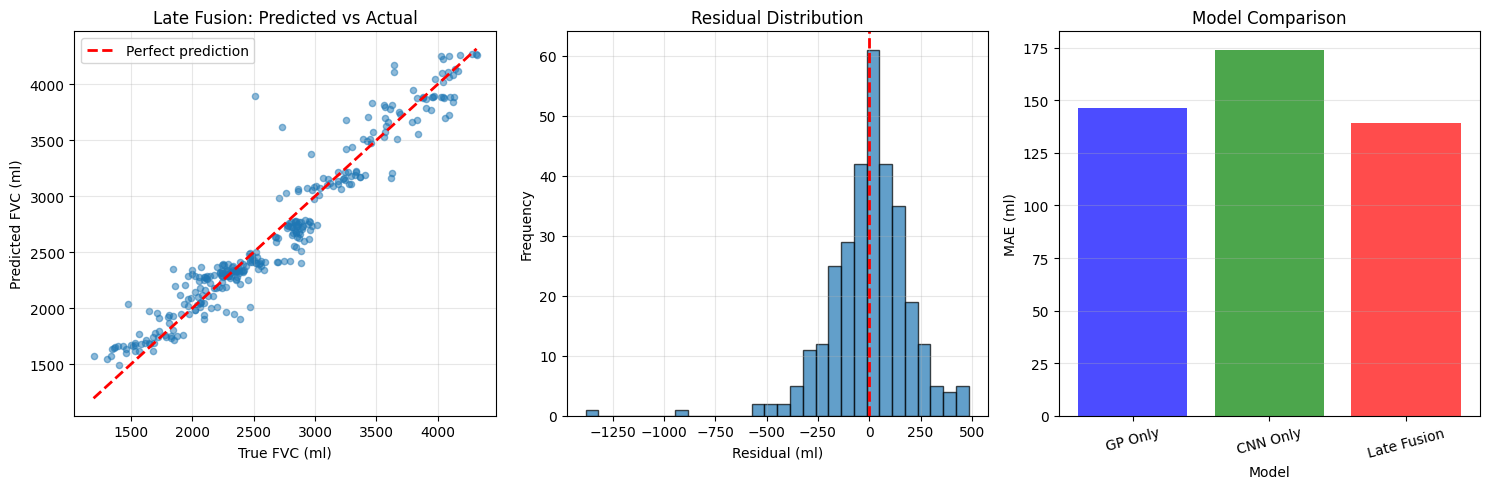

In [ ]:
from preprocessing.tabular_preprocessing import fvc_scaler, time_scaler  

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get GP predictions (already computed above)
# Similarly, cnn_val_predictions have been computed above
print("Preparing GP predictions...")
# Match GP predictions to CNN predictions length (same validation set)
gp_val_predictions = gp_y_pred[:len(cnn_val_predictions)].reshape(-1, 1)
y_true_stacked = gp_y_true[:len(cnn_val_predictions)]

print(f"GP predictions shape: {gp_val_predictions.shape}")

# Stack predictions as features (both are in standardized space)
print("\nStacking predictions...")
X_stacked = np.column_stack([gp_val_predictions, cnn_val_predictions])

# Fit linear regression to find optimal weights (in standardized space)
print("Training linear regression for optimal weights...")
lr_model = LinearRegression()
lr_model.fit(X_stacked, y_true_stacked)

# Get final predictions (still in standardized space)
y_final_pred_scaled = lr_model.predict(X_stacked)

print("\nDe-standardizing predictions...")
y_final_pred = fvc_scaler.inverse_transform(y_final_pred_scaled.reshape(-1, 1)).flatten()
y_true_real = fvc_scaler.inverse_transform(y_true_stacked.reshape(-1, 1)).flatten()
gp_val_predictions_real = fvc_scaler.inverse_transform(gp_val_predictions).flatten()

# Calculate metrics on DE-STANDARDIZED values
mae_final, _, r2_final = eval_metrics(y_true_real, y_final_pred)
lll_final = laplace_log_likelihood(y_true_real, y_final_pred, y_std)

print(f"\n=== Late Fusion Results (Real FVC values) ===")
print(f"GP Weight: {lr_model.coef_[0]:.4f}")
print(f"CNN Weight: {lr_model.coef_[1]:.4f}")
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"\nFinal MAE: {mae_final:.2f} ml")
print(f"Final R²: {r2_final:.4f}")
print(f"Final Laplace Log-Likelihood: {lll_final:.4f}")

# Compare with individual models (de-standardized)
print(f"\n=== Individual Model Performance (Real FVC values) ===")
gp_mae_real, _, gp_r2_real = eval_metrics(y_true_real, gp_val_predictions_real)
print(f"GP-only MAE: {gp_mae_real:.2f} ml")
print(f"GP-only R²: {gp_r2_real:.4f}")

cnn_mae, _, cnn_r2 = eval_metrics(cnn_val_targets_real, cnn_val_predictions_real)
print(f"CNN-only MAE: {cnn_mae:.2f} ml")
print(f"CNN-only R²: {cnn_r2:.4f}")

# Visualize results (using REAL FVC values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_true_real, y_final_pred, alpha=0.5, s=20)
plt.plot([y_true_real.min(), y_true_real.max()], 
         [y_true_real.min(), y_true_real.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC (ml)')
plt.ylabel('Predicted FVC (ml)')
plt.title('Late Fusion: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
residuals_final = y_true_real - y_final_pred
plt.hist(residuals_final, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (ml)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
models = ['GP Only', 'CNN Only', 'Late Fusion']
maes = [gp_mae_real, cnn_mae, mae_final]
r2s = [gp_r2_real, cnn_r2, r2_final]

x_pos = np.arange(len(models))
plt.bar(x_pos, maes, alpha=0.7, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('MAE (ml)')
plt.title('Model Comparison')
plt.xticks(x_pos, models, rotation=15)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Approach 2: Early Fusion

For early fusion, we will use a ResNet3D CNN encoder and LSTM encoder for imaging and patient data feature extraction respectively. Afterwards, the outputs from the previous 2 models will be concatenated and fed into a RNN fusion model to train based on the tabular time-series feature.

In [ ]:
# Directly import pre-computed results from script under 'models' / 'joint_fusion_process.py'
# if first time running, will take quite long due to 'preprocessing' / 'image_preprocessing.py'
import random
from models.joint_fusion_process import jf_validation_results, y_true_list, y_pred_list, y_sigma_list
from evaluation.eval_template import eval_metrics, laplace_log_likelihood

Using device: cuda
Loading in preprocessed image scans...
Loaded final jointFusion_model on device: cuda
Computing results on validation set...
Results computed!



=== Early Fusion Results (Real FVC values) ===

Final MAE: 256.17 ml
Final R²: 0.7911
Laplace Log Likelihood: -7.2619


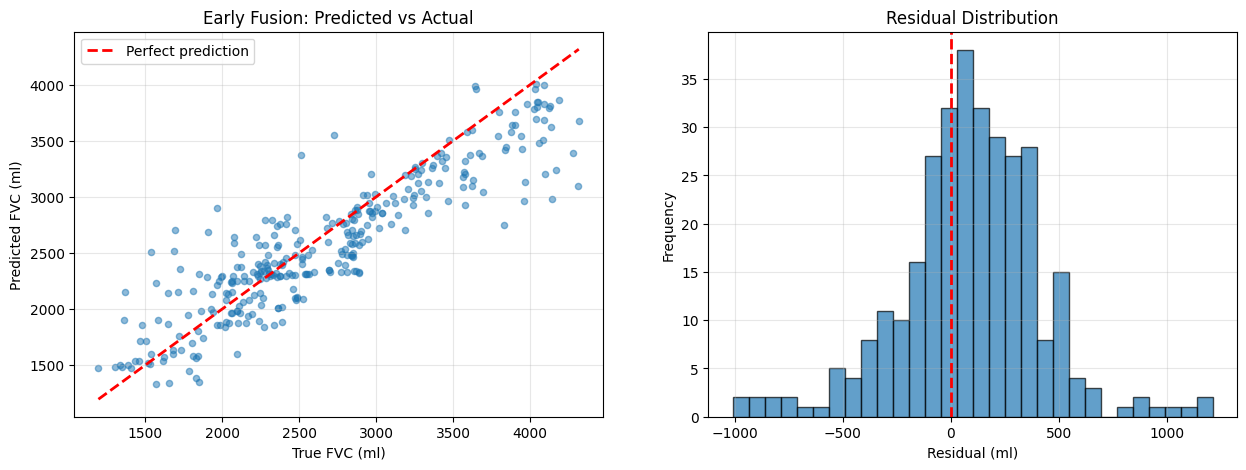

In [ ]:
# Calculate metrics for early fusion results
print(f"\n=== Early Fusion Results (Real FVC values) ===")
jf_mae, jf_rmse, jf_r2 = eval_metrics(y_true_list, y_pred_list)
jf_lll = laplace_log_likelihood(y_true_list, y_pred_list, y_sigma_list)
print(f"\nFinal MAE: {jf_mae:.2f} ml")
print(f"Final R²: {jf_r2:.4f}")
print(f"Laplace Log Likelihood: {jf_lll:.4f}")

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_true_list, y_pred_list, alpha=0.5, s=20)
plt.plot([y_true_list.min(), y_true_list.max()], 
         [y_true_list.min(), y_true_list.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True FVC (ml)')
plt.ylabel('Predicted FVC (ml)')
plt.title('Early Fusion: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
jf_residuals = y_true_list - y_pred_list
plt.hist(jf_residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (ml)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.grid(True, alpha=0.3)


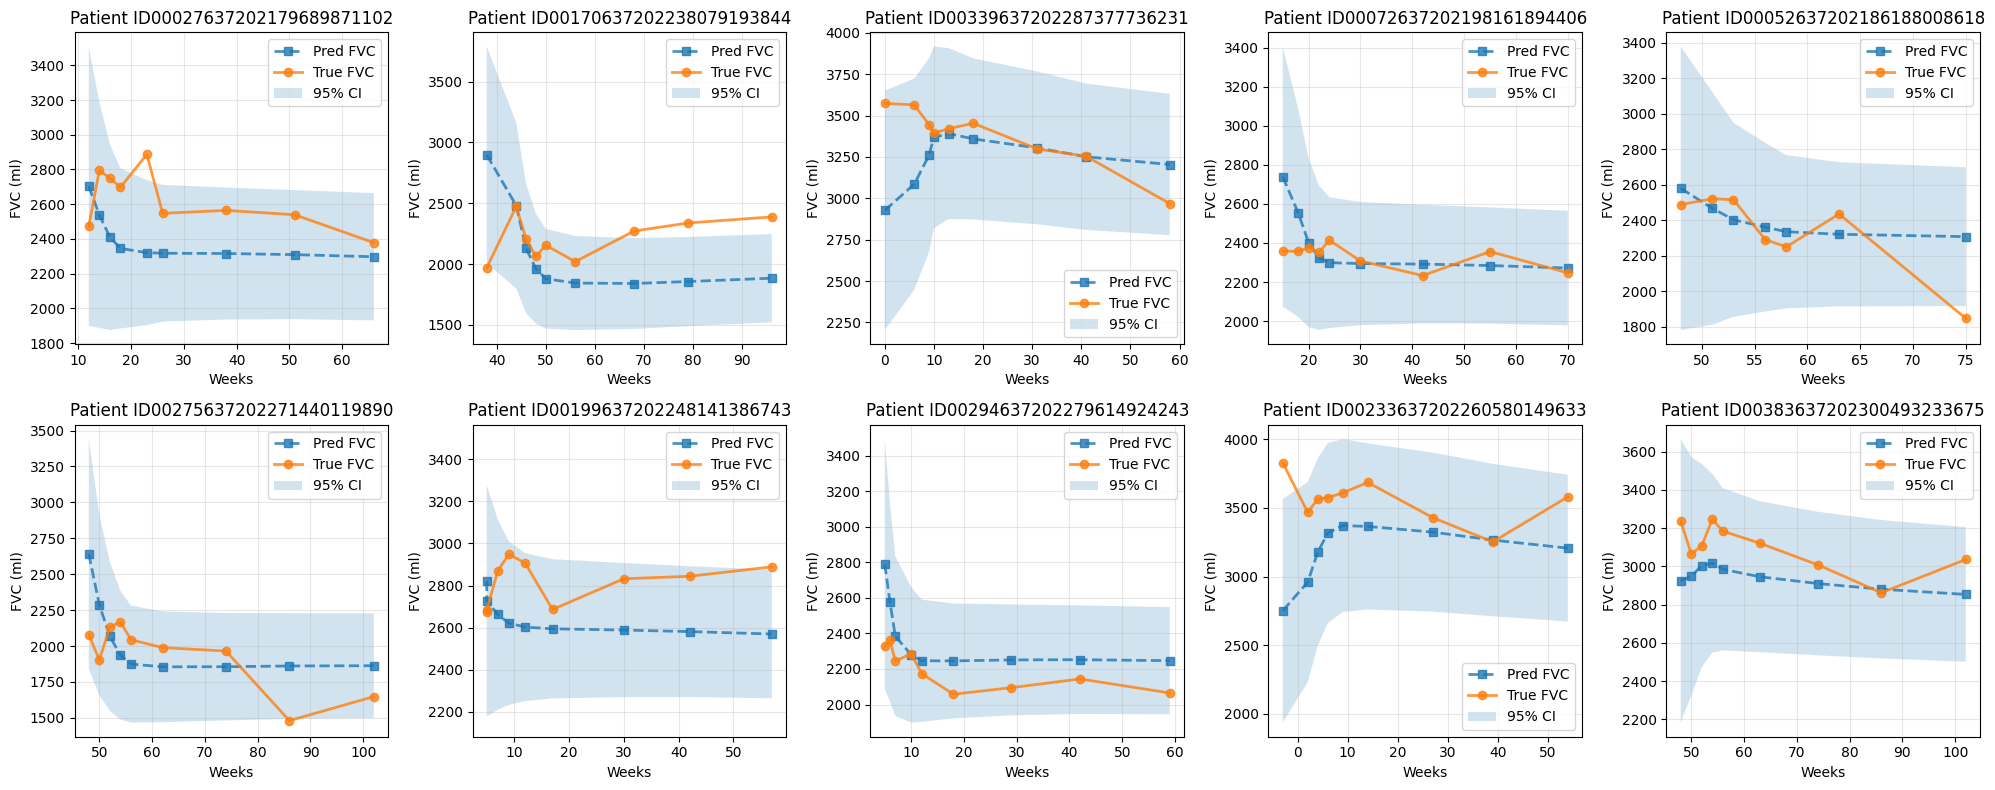

In [ ]:
# Visualise results for 10 random validation patients
random_patients = random.sample(list(jf_validation_results.items()), 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, patient_results in enumerate(random_patients):
    patient = patient_results[0]
    weeks = patient_results[1]['weeks']
    y_pred = patient_results[1]['y_pred']
    y_true = patient_results[1]['y_true']
    y_sigma = patient_results[1]['y_sigma']

    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.plot(weeks, y_pred, 's--', alpha=0.8, label='Pred FVC', linewidth=2, markersize=6)
    ax.plot(weeks, y_true, 'o-', alpha=0.8, label='True FVC', linewidth=2, markersize=6)
    ax.fill_between(
        x = weeks,
        y1 = y_pred - 1.96*y_sigma,
        y2 = y_pred + 1.96*y_sigma,
        alpha=0.2,
        label="95% CI"
    )
    ax.set_xlabel('Weeks')
    ax.set_ylabel('FVC (ml)')
    ax.set_title(f'Patient {patient}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare metrics for baseline vs diff approaches

In [ ]:
# Temporary Cell to manually assign metric values
baseline_r2 = 0.237579; baseline_mae = 524.067776
gru_r2 = 0.932971; gru_mae = 131.037277; gru_lll = -7.729821
gp_r2_real = 0.927219; gp_mae_real = 146.369275; gp_lll = -4.598533
cnn_r2 = 0.904324; cnn_mae = 174.073216; 
r2_final = 0.930326; mae_final = 138.993293; lll_final = -7.378718
jf_r2 = 0.791128; jf_mae = 256.166901; jf_lll = -7.261912

In [ ]:
import pandas as pd

# Models
models = ["XGBoost (Tabular)", "GRU (Tabular)", "GaussianProcess (Tabular)", 
          "CNN (image)",  "LateFusion", "EarlyFusion"]
models_wrapped = ["XGBoost\n(Tabular)", "GRU\n(Tabular)", "Gaussian\nProcess\n(Tabular)",
                  "CNN\n(image)",  "LateFusion", "EarlyFusion"]
# Corresponding values calculated earlier in above cells
r2_values = [baseline_r2, gru_r2, gp_r2_real, cnn_r2, r2_final, jf_r2]
mae_values = [baseline_mae, gru_mae, gp_mae_real, cnn_mae, mae_final, jf_mae]
lll_values = [None, gru_lll, gp_lll, None, lll_final, jf_lll]

metrics_data = {
    "Model": models,
    "R-squared (↑)": r2_values,
    "MAE (↓)": mae_values,
    "Laplace Log-Likelihood (↑)": lll_values
}

metrics_df = pd.DataFrame(metrics_data)
print("    NOTE: Some models have no LLL value due to non-probabilistic prediction.")
metrics_df


    NOTE: Some models have no LLL value due to non-probabilistic prediction.


,Model,R-squared (↑),MAE (↓),Laplace Log-Likelihood (↑)
0,XGBoost (Tabular),0.237579,524.067776,NaN
1,GRU (Tabular),0.932971,131.037277,-7.729821
2,GaussianProcess (Tabular),0.927219,146.369275,-4.598533
3,CNN (image),0.904324,174.073216,NaN
4,LateFusion,0.930326,138.993293,-7.378718
5,EarlyFusion,0.791128,256.166901,-7.261912


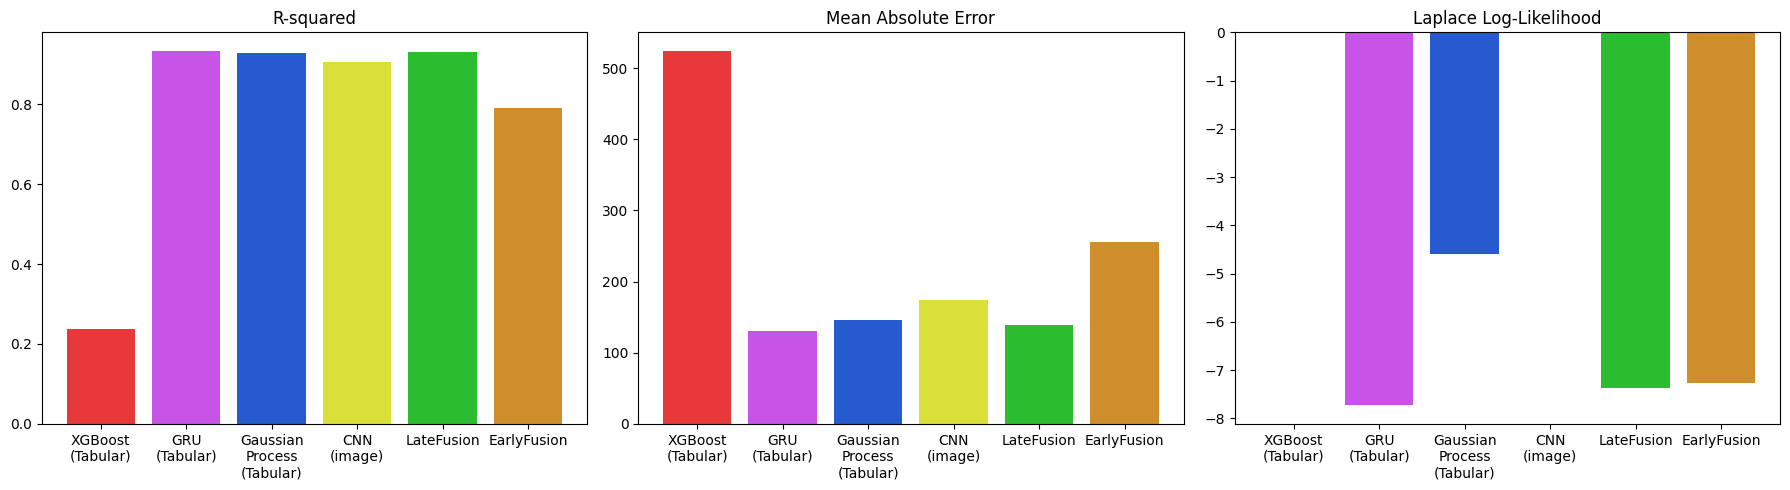

In [ ]:
import matplotlib.pyplot as plt

# colour mappings
model_colors = {
    "XGBoost\n(Tabular)": "#E73939",       
    "GRU\n(Tabular)": "#c754e7",
    "Gaussian\nProcess\n(Tabular)": "#285acf",
    "CNN\n(image)": "#dbe038",          
    "LateFusion": "#2ABD2F",       
    "EarlyFusion": "#cf8e2c" 
}

# plot side by side
fig, axes = plt.subplots(1, 3, figsize=(18,5))

axes[0].bar(models_wrapped, r2_values, color=[model_colors[m] for m in models_wrapped])
axes[0].set_title("R-squared")

axes[1].bar(models_wrapped, mae_values, color=[model_colors[m] for m in models_wrapped])
axes[1].set_title("Mean Absolute Error")

lll_plots = [0, gru_lll, gp_lll, 0, lll_final, jf_lll]
axes[2].bar(models_wrapped, lll_plots, color=[model_colors[m] for m in models_wrapped])
axes[2].set_title("Laplace Log-Likelihood")

plt.tight_layout()
plt.show()

### Metrics explanation:
- R-squared reflects the proportion of variance in FVC explained by the model. Higher values indicate better explanatory power over patient lung function decline.
- MAE provides an intuitive clinical interpretation, representing the average absolute difference between predicted and actual FVC in millilitres.
- Laplace Log-Likelihood assesses not only prediction accuracy but also the quality of predicted uncertainty, rewarding models that are both accurate and well-calibrated.
- Gaussian Process uses marginal log likelihood, which are equivalent in nature with laplace log likelihood.

### Conclusion:
The Late Fusion model achieved a significantly high R-squared and low MAE , indicating superior predictive accuracy. However, its Laplace Log-Likelihood was inferior to the Gaussian approach, suggesting weaker uncertainty calibration. This highlights a trade-off between prediction accuracy and probabilistic reliability. The relatively lower performance of Early Fusion implies that direct joint feature learning may not be optimal under current data constraints, potentially due to limited image diversity (lack of temporal CT-scans) and insufficient cross-modal correlation.